# Lab CMBLenses

## Model

In [1]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [2]:
using Revise
using MicroCanonicalHMC

In [3]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 64);

In [4]:
target = CMBLensingTarget(prob);

In [5]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)

(CMBLensingInferenceTestProblem.var"#to_vec#2"(), CMBLensingInferenceTestProblem.var"#from_vec#3"{Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}(Float32[-4.7993712, -10.132681, -13.010162, -9.098768, -3.4189508, -2.647602, -2.2184951, -1.8052056, -3.8572881, -6.549067  …  -1.4671382f-6, -1.5210153f-6, -1.5569877f-6, -1.597326f-6, -1.6578678f-6, -1.7366059f-6, -1.8154062f-6, -1.8714119f-6, -1.609438, 0.0]))

## Sample

In [6]:
spl=MCHMC(0.01, 0.01*sqrt(50); init_eps=0.01, varE_wanted=0.001, sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.001, 0, 20, 10, "LF", 0.01, nothing, nothing), Hyperparameters(0.01, 0.07071067811865475, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [7]:
samples = Sample(spl, target, 1000; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


1001-element Vector{Any}:
 [-4.781805038452148, -10.115113258361816, -12.992595672607422, -9.081202507019043, -3.4013853073120117, -2.6300344467163086, -2.2009286880493164, -1.7876393795013428, -3.8397207260131836, -6.531499862670898  …  -1.556987626827322e-6, -1.5973259905877057e-6, -1.657867642279598e-6, -1.7366054407830234e-6, -1.815406449168222e-6, -1.8714119960350217e-6, -1.6094379425048828, 0.0, 0.0, 98678.2265625]
 [-4.781803191934301, -10.115115712228013, -12.992616865261052, -9.081252471277814, -3.401385690887315, -2.6300520035126738, -2.200912695674128, -1.787611473058055, -3.8397116940367453, -6.531447650023212  …  -1.5570934109208437e-6, -1.5974194794790956e-6, -1.6579477699863949e-6, -1.7366708778542928e-6, -1.8154588848458998e-6, -1.871459274305282e-6, -1.6093822242635547, -0.00020207959654194564, -0.004849513075896539, 98678.22381507486]
 [-4.78177911569213, -10.115114126067663, -12.992628308505498, -9.081312398464078, -3.401354407067977, -2.6300495877564773, -2.20087798

## Plotting

In [8]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [9]:
rs = [sample[end-3] for sample in samples]
Aϕs = [sample[end-2] for sample in samples];

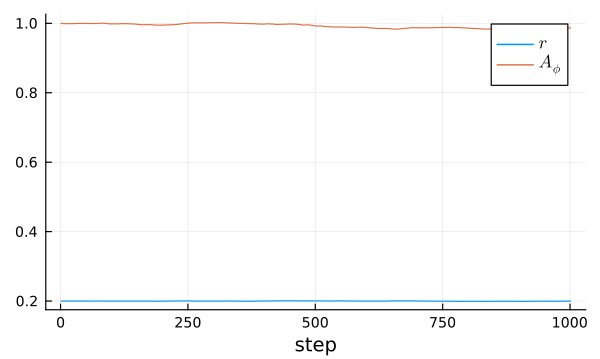

In [10]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [11]:
Energy = [sample[end-1] for sample in samples];
std(Energy)^2/50

8.162299194310981e-7

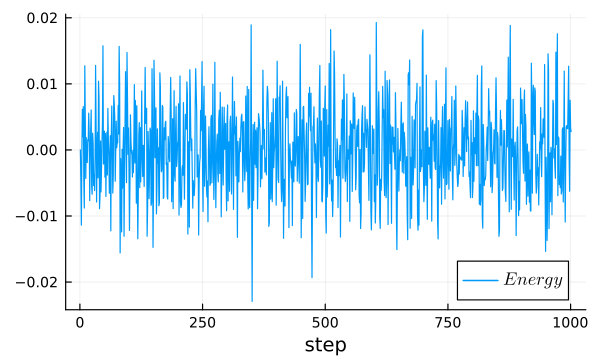

In [12]:
plot(Energy, label=L"Energy", xlabel="step")

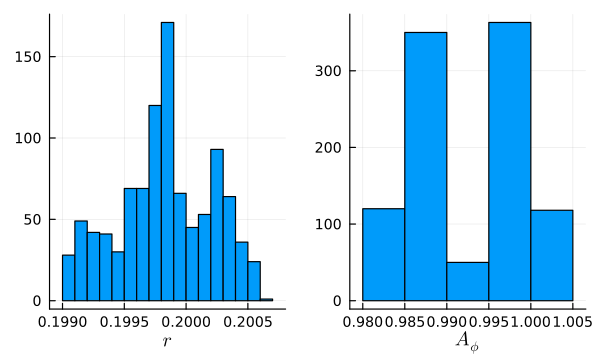

In [13]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))

In [14]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples[end][1:end-2])

12290-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float64, 3}}, LambertMap{Array{Float64, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  -4.779496023542013
 -10.104117366751808
 -12.998275417043978
   ⋮
  -1.6100715398788452
  -0.013022891245782375

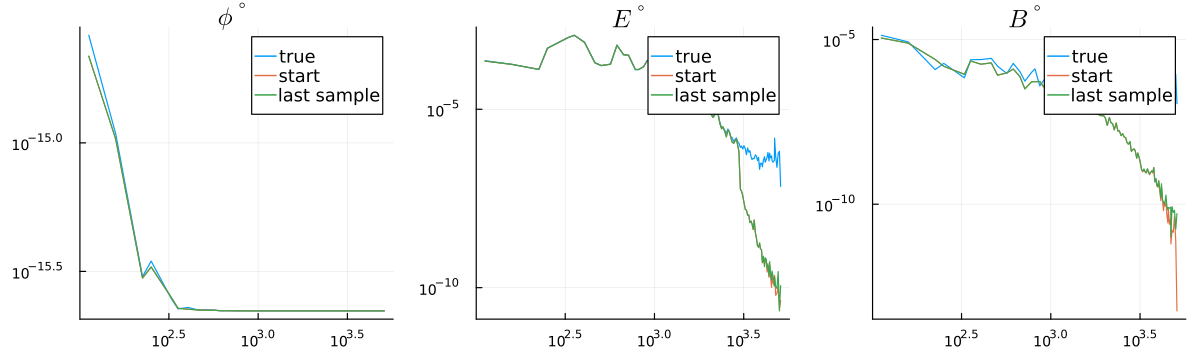

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [15]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300))#, legend=:bottomleft)

In [ ]:
samps = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [ ]:
mp4(anim, "kappa_samples.mp4", fps = 25)